# Generating adversarial images with Keras
Presenting an adversarial mask/patch generator

## Random image transformations for use with the adversarial patch

Test image with random transform: 1


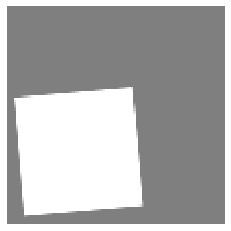

Test image with random transform: 2


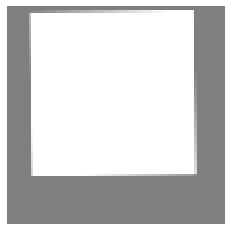

In [3]:
from patch.transformations import test_random_transform
for i in range(2):
  print("Test image with random transform: %s" % (i+1))
  test_random_transform(min_scale=0.25, max_scale=2.0, max_rotation=22.5)

In [4]:
import json
from patch.model_state import ModelContainer

with open('config.json') as json_file:
    config = json.load(json_file)
    
STEPS = config["patch_epochs"]

# custom_weights_path points to a pre-trained model on 10 classes of images
mc = ModelContainer("SimpleVGG16", custom_weights_path="cool_net.h5")

print("Training SimpleVGG16")
mc.reset_patch()
for i in range(STEPS):
    loss = mc.train_step(scale=(0.1, 1.0))
    if i % int(STEPS/10) == 0:
        print("[%s] loss: %s" % (i, loss))

print("Done training!")
patch = mc.patch()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://gi

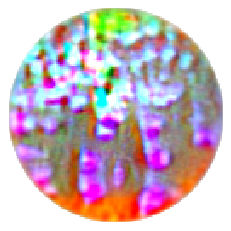

In [5]:
from patch.constants import PATCH_SHAPE
from patch.image import show
from patch.model_state import circle_mask

def show_patch(patch):
  circle = circle_mask(PATCH_SHAPE)
  show(circle * patch + (1-circle))
    
show_patch(patch)